In [ ]:
"""
Replaced -9 with average
Renormalised all event feature to -1 and 1
removed TTjet and Gjet 
batch sampling according to weights
"""

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import copy
import train_evaluate_GanelsClosest as te
import csv 
hep.style.use("CMS")
auclist=[]
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def separate_output_score(output_score,y):
    dict_ = {'pred':output_score.cpu().detach().numpy().flatten(),'true':y}
    temp_df = pd.DataFrame(dict_)
    signal_output_score = temp_df.loc[temp_df['true'] == 1]['pred']
    background_output_score = temp_df.loc[temp_df['true'] == 0]['pred']
    return signal_output_score,background_output_score



d:\Languages\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


d:\UserFiles\Imperial\Year 4\Msci\Git_Final\CMS_Physics_PNN\Neural Networks\Final_Neural_Network\train_evaluate_GanelsClosest.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['weight_central'][y_train==0] *= (x_train['weight_central'][y_train==1].sum() / x_train['weight_central'][y_train==0].sum())
d:\UserFiles\Imperial\Year 4\Msci\Git_Final\CMS_Physics_PNN\Neural Networks\Final_Neural_Network\train_evaluate_GanelsClosest.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['weight_central'][y_test==0] *= (x_test['weight_central'][y_test==1].sum() / x_test['weight_central'][y_test==0].sum())


Epoch: 0
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 35
Epoch: 40
Epoch: 45
Early stopping triggered
>> Training finished
Best model at epoch 43 with loss of 2.9203934900579043e-05
Printing AUC Score:0.9921902555582685 for signal GluGluToRadionToHHTo2G2Tau_M-320 of architecture [50, 50, 50]


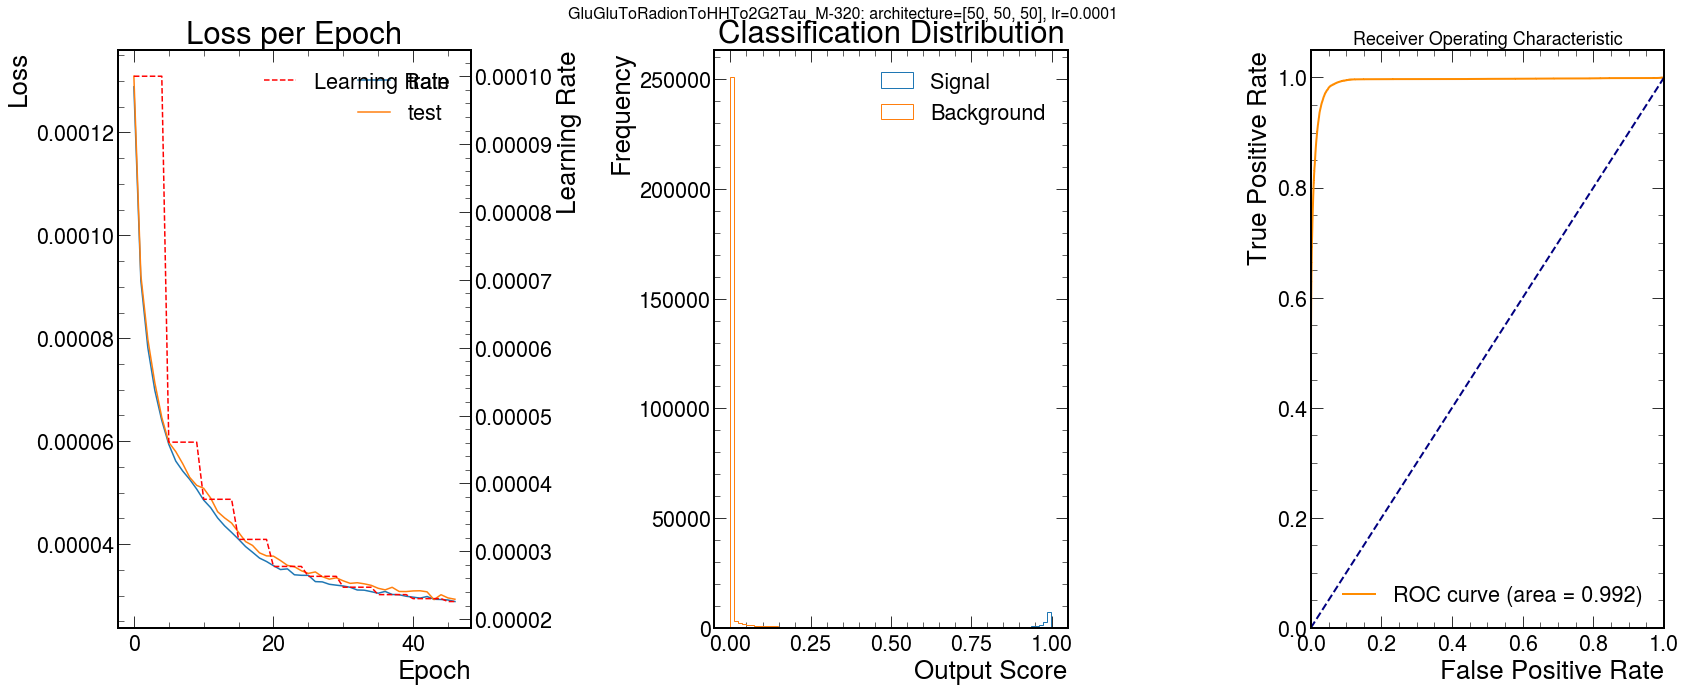

In [2]:

architectures= [[50,50,50]] 

learningrate = 0.0001

plot_learning_rate='yes'
scheduler_type='Custom'
top_number=27
               
all_features=pd.read_csv('ORDEREDFEATURESUITABILITY.csv')

allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']
allmasses=['320']

for mass in allmasses:
    signal_names="GluGluToRadionToHHTo2G2Tau_M-"+mass #choose signal to analyse
    auclist=[]
    for nodes in architectures:
        feature_info = pd.read_csv("ROC_feature_info.csv")
        
        signal_df, background_df, combine_df, add_to_test_df = te.read_dataframes(signal_name = signal_names)
        
        x_train,x_test = te.getTrainTestSplit(combine_df,add_to_test_df)
        #x_train,x_test = te.getTrainTestSplit(combine_df)
        
        feature_list = all_features[signal_names].tolist()[0:top_number]
        
        
        epoch = 500
    #        models,epoch_loss_train,epoch_loss_test,output_score = te.trainNetwork(x_train, x_test, feature_list, 0.001, epoch = epoch, outdir=None, save_models=False, batch_size = 2048)
    
        models,epoch_loss_train,epoch_loss_test,output_score,output_score_train, learning_rate_epochs = te.trainNetwork_no_weights(x_train, x_test, feature_list, learningrate, epoch = epoch, outdir=None, save_models=False,
                            batch_size = 2048, nodes = nodes, model_type='char',scheduler_type=scheduler_type)        
        
        
        signal_output_score,background_output_score = separate_output_score(output_score,x_test['y'])
        
        fpr, tpr, thresholds = roc_curve(x_test['y'], output_score.cpu().detach().numpy())
        roc_auc = auc(fpr, tpr)
        print(f'Printing AUC Score:{roc_auc} for signal {signal_names} of architecture {(nodes)}')
        
        fig, axs = plt.subplots(1, 3, figsize=(24, 10))
           
        axs[0].plot(epoch_loss_train, label = 'train')
        axs[0].plot(epoch_loss_test, label = 'test')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_title('Loss per Epoch')
        axs[0].legend(loc='upper right')
        if plot_learning_rate == 'yes':
            ax1_twin = axs[0].twinx()
            ax1_twin.plot(learning_rate_epochs, label='Learning Rate', linestyle='--', color='red')
            ax1_twin.set_ylabel('Learning Rate')
            ax1_twin.tick_params(axis='y')
            
       # ax1_twin.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

        axs[1].hist(signal_output_score, label = 'Signal',bins=80,histtype='step')
        axs[1].hist(background_output_score, label = 'Background',bins=80,histtype='step')
        axs[1].set_xlabel("Output Score")
        axs[1].set_title('Classification Distribution')
        axs[1].set_ylabel("Frequency")
        axs[1].legend()
        
        axs[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
        axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[2].set_xlim([0.0, 1.0])
        axs[2].set_ylim([0.0, 1.05])
        axs[2].set_xlabel('False Positive Rate')
        axs[2].set_ylabel('True Positive Rate')
        axs[2].set_title('Receiver Operating Characteristic',fontsize=18)
        axs[2].legend(loc="lower right")
        plt.tight_layout()
        plt.legend()
        #plt.title(f'{signal_names[l]}')
        fig.suptitle(f'{signal_names}: architecture={nodes}, lr={learningrate}', fontsize=16)
        plt.show()
        #plt.savefig(f'lossclassROC_m={mass}_arch={nodes}_lr={learningrate}.png')
        #plt.savefig(f'savetrial1000.png')
    
        
        auclist.append([signal_names,roc_auc,nodes])
        
    featurescore_df = pd.DataFrame(auclist, columns=['signal', 'score', 'nodes per hidden layer'])
    
    #output_file_path = f'OptimisedArch310124_{mass}_lr{learningrate}_[50,50,50].csv'
    #featurescore_df.to_csv(output_file_path, index=False)
         
